In [10]:
import cartopy
import cartopy.crs as ccrs
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import math

In [11]:
df_grid = pd.read_excel('./grid_connected.xlsx', index_col=0)
df_substations = pd.read_excel('./substations_connected_grid.xlsx', index_col=0)
df_powerplants = pd.read_excel('./power_plants_connected_grid.xlsx', index_col=0)

gdf_substations = gpd.GeoDataFrame(
    df_substations, geometry=gpd.points_from_xy(df_substations.lon, df_substations.lat))

for index, row in gdf_substations.iterrows():
    aggregated_capacity = df_powerplants[df_powerplants.node == index]['capacity'].agg('sum')
    gdf_substations.loc[index, 'aggregated_capacity'] = aggregated_capacity

In [12]:
for index, row in df_grid.iterrows():
    df_grid.loc[index, 'start_lon'] = df_substations.loc[row.substation_1, 'lon']
    df_grid.loc[index, 'start_lat'] = df_substations.loc[row.substation_1, 'lat']
    
    df_grid.loc[index, 'end_lon'] = df_substations.loc[row.substation_2, 'lon']
    df_grid.loc[index, 'end_lat'] = df_substations.loc[row.substation_2, 'lat']
    
gdf_grid = gpd.GeoDataFrame(
    df_grid, geometry=gpd.points_from_xy(df_grid.start_lon, df_grid.start_lat), crs=4326)

for index, row in gdf_grid.iterrows():
    gdf_grid.loc[index, 'geometry'] = LineString([(row.start_lon, row.start_lat), (row.end_lon, row.end_lat)])
    
gdf_grid = gdf_grid.drop(columns=['start_lon', 'end_lon', 'start_lat', 'end_lat'])
gdf_substations = gdf_substations.drop(columns=['lon', 'lat'])

In [13]:
gdf_network = pd.concat([gdf_substations, gdf_grid])
#gdf_network = gdf_network[~gdf_network.geometry.is_empty]

C:\Users\balaz\SoftwareDeveloping\TUD\thesis\FBMC\fbmc_env2\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [201]:
# (RTE) remove: 594, 423, 568, 1127, 1011, 327, 585, 14, 1209, 363, 215, 
# 1012, 661, 764, 838, 1272, 254, 1055, 755, 589, 116, 967, 863, 1023, 11, 1068, 282
comp_nodes = [282]
comp = gdf_network[gdf_network.substation_1.isin(comp_nodes) & gdf_network.substation_2.isin(comp_nodes)]

In [14]:
gdf_network.explore()

In [15]:
edgelist = []
for index, row in df_grid.iterrows():
    edgelist.append((row.substation_1, row.substation_2))

Grid = nx.Graph(edgelist)

positions = {}
node_attributes = {}
edge_attributes = {}

for index, row in df_substations.iterrows():
    positions[index] = (row.lon, row.lat)
    node_attributes[index] = {
        "zone": row.zone
    }
    
for index, row in df_substations.iterrows():
    positions[index] = (row.lon, row.lat)
    node_attributes[index] = {
        "zone": row.zone
    }
    
nx.set_node_attributes(Grid, node_attributes)

C:\Users\balaz\SoftwareDeveloping\TUD\thesis\FBMC\fbmc_env2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


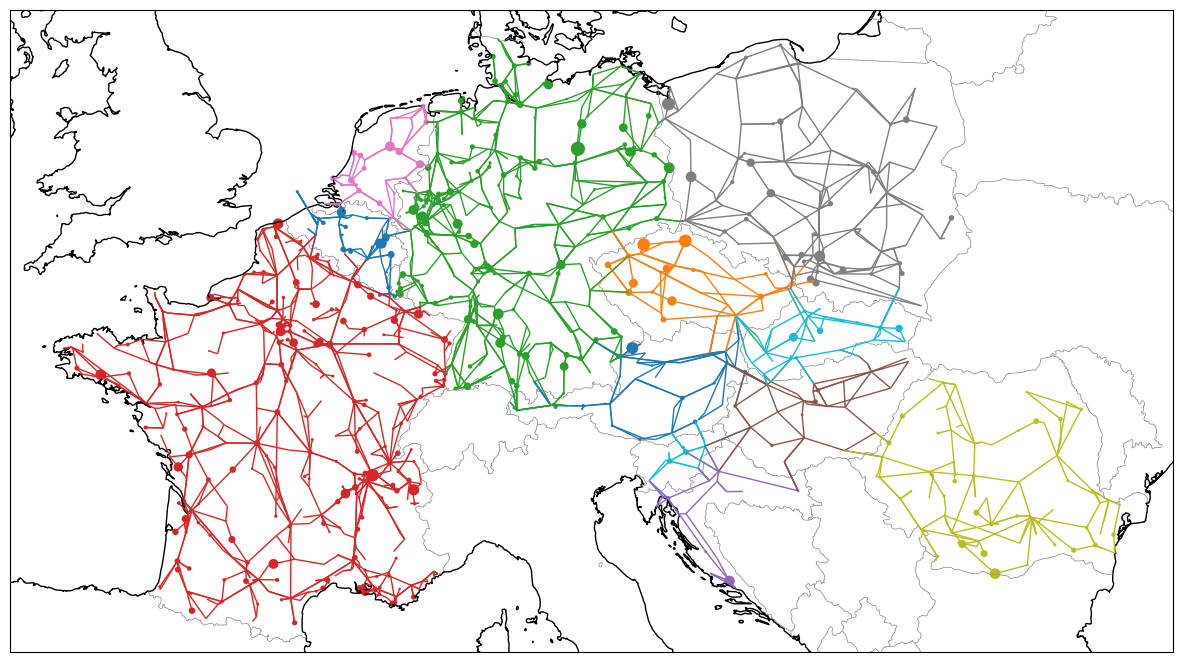

In [16]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gdf_network.plot(
    ax=ax,
    column='zone',
    markersize=gdf_network.aggregated_capacity/0.8e2,
    linewidth=1
)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color='grey', linewidth=0.5)

In [19]:
display(df_grid[df_grid.susceptance != 0])

,name,eic,tso,substation_1,substation_2,voltage,resistance,reactance,susceptance,length,zone,tieline,start_lon,start_lat,end_lon,end_lat,geometry
0,Eula - Röhrsdorf 203,11TD8L203------C,50HERTZ,744,570,220,4.0937,18.349,161.163703,51.511,DE,False,12.518222,51.157073,12.813910,50.857919,"LINESTRING (12.51822 51.15707, 12.81391 50.85792)"
1,Röhrsdorf - Weida 207,11TD8L207------H,50HERTZ,570,148,220,7.5895,31.888,348.716785,98.324,DE,False,12.813910,50.857919,12.044983,50.781257,"LINESTRING (12.81391 50.85792, 12.04498 50.78126)"
2,Eula - Weida 208,11TD8L208------9,50HERTZ,744,148,220,5.0537,19.541,264.239358,67.550,DE,False,12.518222,51.157073,12.044983,50.781257,"LINESTRING (12.51822 51.15707, 12.04498 50.78126)"
3,Bentwisch - Güstrow 275,11TD8L275------7,50HERTZ,695,167,220,1.9090,12.055,158.084942,41.418,DE,False,12.213561,54.112000,12.186985,53.815775,"LINESTRING (12.21356 54.11200, 12.18698 53.81578)"
4,Wuhlheide - Thyrow 291,11TD8L291------L,50HERTZ,687,6,220,2.9672,11.191,266.784,38.882,DE,False,13.506128,52.473823,13.305753,52.230782,"LINESTRING (13.50613 52.47382, 13.30575 52.23078)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,Buers - Westtirol rt (422),10T-AT-DE-000053,TRANSNETBW,870,794,400,0.9900,14.270,168.7035,91.400,DE,True,9.810917,47.142645,10.873936,47.244424,"LINESTRING (9.81092 47.14265, 10.87394 47.24442)"
2848,Buers - Westtirol ws (421),10T-AT-DE-000061,TRANSNETBW,870,794,220,1.0000,14.365,170.1173,92.000,DE,True,9.810917,47.142645,10.873936,47.244424,"LINESTRING (9.81092 47.14265, 10.87394 47.24442)"
2849,Buers - Y-Werben,11T-D4-D7-00001W,TRANSNETBW,870,987,220,0.5950,90.800,70.41881,47.000,DE,True,9.810917,47.142645,9.716747,47.432667,"LINESTRING (9.81092 47.14265, 9.71675 47.43267)"
2850,Eichstetten - Muhlbach rt (Ill),10T-DE-FR-00002G,TRANSNETBW,543,236,400,0.3800,4.100,70.34027,17.380,DE,True,7.753495,48.099356,7.555917,47.907355,"LINESTRING (7.75350 48.09936, 7.55592 47.90735)"
